In [3]:
from datasets import inspect_dataset, load_dataset_builder, load_dataset, get_dataset_split_names
import datasets
import torch
import pandas as pd
import numpy as np
import matplotlib as plt
import os
from torch.utils.data import Dataset, DataLoader
from tokenizers import CharBPETokenizer
from transformers import AutoTokenizer
from tqdm import tqdm

ImportError: cannot import name 'DatasetCard' from 'huggingface_hub' (/Users/sangmin/anaconda3/envs/pytorch/lib/python3.9/site-packages/huggingface_hub/__init__.py)

# Save dataset from huggingface as files (for practice)

In [23]:
dataset = load_dataset('iwslt2017', 'iwslt2017-en-de')

In [25]:
df = pd.DataFrame(dataset['train']['translation'], columns=['en', 'de'])
df.head()

,en,de
0,"Thank you so much, Chris.","Vielen Dank, Chris."
1,And it's truly a great honor to have the oppor...,"Es ist mir wirklich eine Ehre, zweimal auf die..."
2,"I have been blown away by this conference, and...",Ich bin wirklich begeistert von dieser Konfere...
3,"And I say that sincerely, partly because I ne...","Das meine ich ernst, teilweise deshalb -- weil..."
4,Put yourselves in my position.,Versetzen Sie sich mal in meine Lage!


In [35]:
df['en_token_cnt'] = df.en.apply(lambda sent: len(sent.split()))
df['de_token_cnt'] = df.de.apply(lambda sent: len(sent.split()))
df.head()

,en,de,en_token_cnt,de_token_cnt
0,"Thank you so much, Chris.","Vielen Dank, Chris.",5,3
1,And it's truly a great honor to have the oppor...,"Es ist mir wirklich eine Ehre, zweimal auf die...",19,16
2,"I have been blown away by this conference, and...",Ich bin wirklich begeistert von dieser Konfere...,30,22
3,"And I say that sincerely, partly because I ne...","Das meine ich ernst, teilweise deshalb -- weil...",10,13
4,Put yourselves in my position.,Versetzen Sie sich mal in meine Lage!,5,7


<Axes: ylabel='Frequency'>

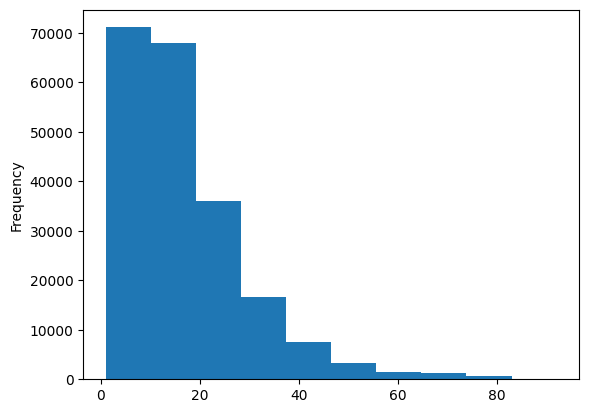

In [46]:
df['en_token_cnt'].plot(kind='hist')
# df['de_token_cnt'].max()

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 206112
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8079
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 888
    })
})

In [21]:
def extract_dataset(path: str, dataset_dict: datasets.DatasetDict, language_pair: str):
    langs = language_pair.split('-')
    for dataset_split, dataset in dataset_dict.items():
        for lang in langs:
            full_path = os.path.join(path, f"{dataset_split}.{lang}")
            
            with open(full_path, "w", encoding="utf-8") as f:
                for data in dataset:
                    data_lang = data['translation'][lang]
                    f.write(data_lang + '\n')

In [22]:
extract_dataset('./dataset/', dataset, language_pair='en-de')

In [4]:
VOCAB_SIZE = 37000

en_tokenizer = CharBPETokenizer(lowercase=False, split_on_whitespace_only=True)
en_tokenizer.train(
    files='./dataset/train.en',
    vocab_size = VOCAB_SIZE,
    min_frequency = 1
)

output = en_tokenizer.encode("And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.")
print(output)
output.tokens

NameError: name '퍠ᄎᄆ' is not defined

In [79]:
de_tokenizer = CharBPETokenizer(lowercase=False, split_on_whitespace_only=True)
de_tokenizer.train(
    files='./dataset/train.de',
    vocab_size = VOCAB_SIZE,
    min_frequency = 1
)

output = de_tokenizer.encode("Es ist mir wirklich eine Ehre, zweimal auf dieser Bühne stehen zu dürfen. Tausend Dank dafür.")
output.tokens

['E',
 's</w>',
 'ist</w>',
 'm',
 'ir</w>',
 'w',
 'ir',
 'k',
 'l',
 'ich</w>',
 'e',
 'ine</w>',
 'E',
 'h',
 're,</w>',
 'z',
 'we',
 'im',
 'al</w>',
 'au',
 'f</w>',
 'di',
 'es',
 'er</w>',
 'B',
 'ü',
 'h',
 'ne</w>',
 'ste',
 'h',
 'en</w>',
 'z',
 'u</w>',
 'd',
 'ü',
 'r',
 'f',
 'en.</w>',
 'T',
 'a',
 'us',
 'end</w>',
 'D',
 'ank</w>',
 'da',
 'f',
 'ü',
 'r.</w>']

In [99]:
class TranslationDataset(Dataset):
    def __init__(self, path, split, language_pair='en-de', max_length=256) -> None:
        super().__init__()
        
        src_lang, tgt_lang = language_pair.split('-')

        full_path = os.path.join(path, f'{split}.{src_lang}')
        with open(full_path, 'r', encoding='utf-8') as f:
            sents = f.readlines()
        src_sents = [sent.rstrip() for sent in sents]

        full_path = os.path.join(path, f'{split}.{tgt_lang}')
        with open(full_path, 'r', encoding='utf-8') as f:
            sents = f.readlines()
        tgt_sents = [sent.rstrip() for sent in sents]
    
        self.src_sents = src_sents
        self.tgt_sents = tgt_sents

        self.src_tokenizer = en_tokenizer
        self.tgt_tokenizer = de_tokenizer

        self.max_length = max_length
    
    def __len__(self):
        return len(self.src_sents)

    def __getitem__(self, index):
        src_sent = self.src_sents[index]
        tgt_sent = self.tgt_sents[index]

        src_token = self.src_tokenizer.encode(src_sent).ids
        tgt_token = self.tgt_tokenizer.encode(tgt_sent).ids

        return {
            'input': torch.tensor(src_token),
            'output': torch.tensor(tgt_token)
        }
    


In [100]:
train_dataset = TranslationDataset('./dataset/', 'train', 'en-de')
train_dataset[0]

{'input': tensor([ 948,  288,  371, 4509, 3208,  814]),
 'output': tensor([4460,  275,  300,   34,  245,  627, 3208,  814])}

In [107]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(samples):
    inputs = [sample['input'] for sample in samples]
    outputs = [sample['output'] for sample in samples]

    padded_inputs = pad_sequence(inputs, batch_first=True)
    padded_outputs = pad_sequence(outputs, batch_first=True)

    return {
        'input': padded_inputs,
        'output': padded_outputs
    }

In [109]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [113]:
for step, batch in enumerate(train_loader):
    src, target = batch.values()
    print(src.shape, target.shape)
    break

torch.Size([8, 58]) torch.Size([8, 121])
